In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

#from litovchenko_inclass1 import normalize, recognize_digits

from skimage import io
from skimage.feature import canny
import cv2
import os

%matplotlib inline

# Normalize and crop

In [5]:
fname = './train_8'
image_full = cv2.imread(fname, 0) / 255
plt.figure(figsize=(13, 13))
plt.imshow(image_full, cmap='gray')

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

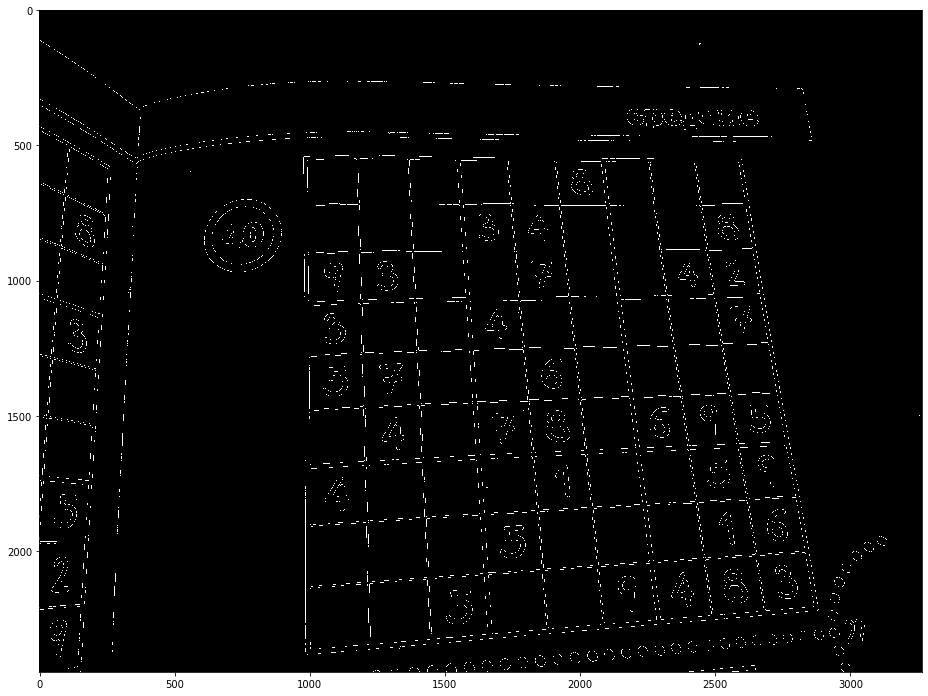

In [3]:
edges_full = canny(image_full, sigma=2)
plt.figure(figsize=(13, 13))
io.imshow(edges_full)

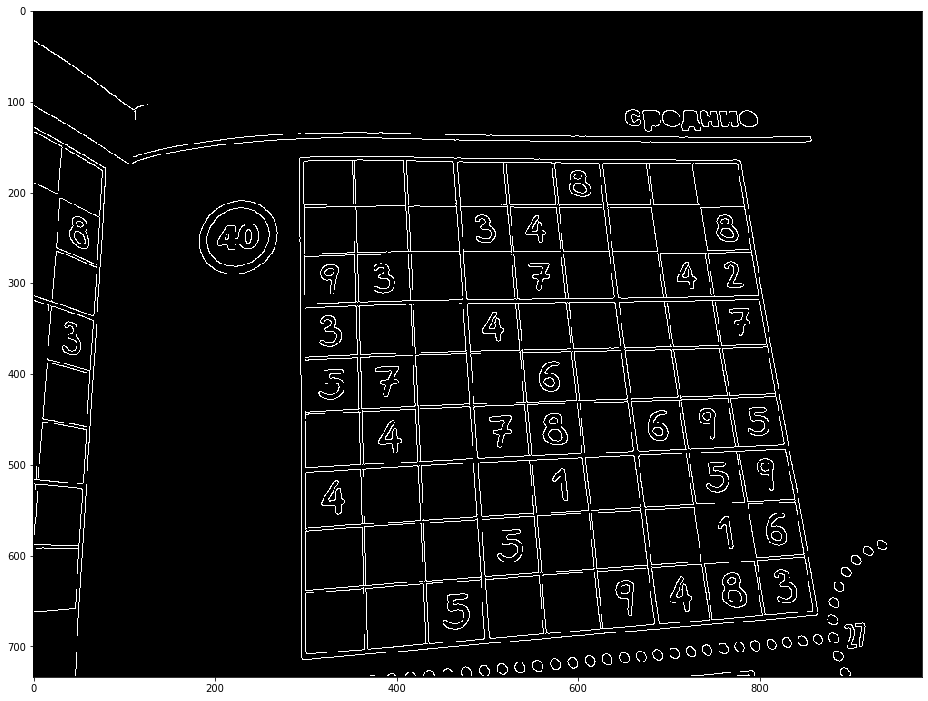

In [4]:
from skimage.transform import rescale
image_scaled = rescale(image_full, 0.3, multichannel=False)
edges = canny(image_scaled,
              sigma=1.1,
              low_threshold=0.66*np.mean(image_scaled),
              high_threshold=1.33*np.mean(image_scaled))
plt.figure(figsize=(13, 13))
io.imshow(edges)

##  Find all contours and selecting the largest one

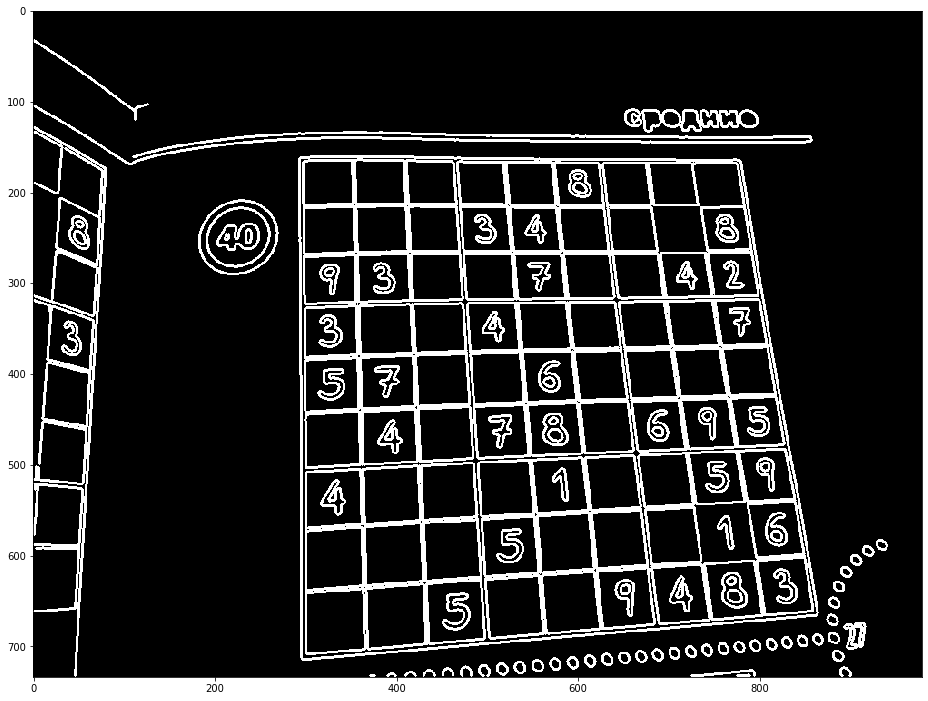

In [5]:
from skimage.morphology import dilation, disk

selem = disk(1)
edges = dilation(edges, selem)
plt.figure(figsize=(13, 13))
io.imshow(edges)

##  Step 2b: find all contours and selecting the largest one

In [6]:
import cv2

# we need to convert image to uint to apply findContours
edges = (edges).astype(np.uint8)

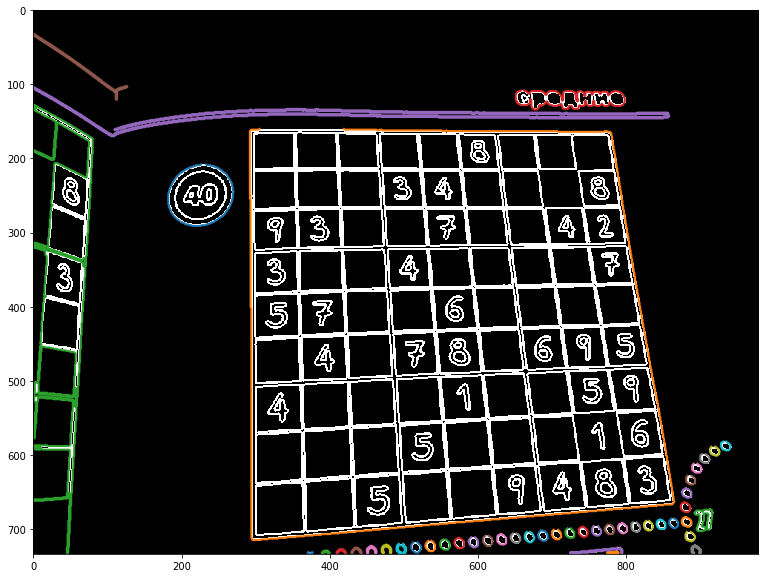

In [7]:
ext_contours = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(edges, cmap=plt.cm.gray)

for n, contour in enumerate(ext_contours):
    contour = np.array(contour).squeeze() # we need to remove one dim, se below
    if contour.ndim > 1:
        ax.plot(contour[:, 0], contour[:, 1], linewidth=2)

In [8]:
contour = max(ext_contours, key= lambda x : cv2.contourArea(x))

# we need to remove one unnecessary dimension
print(contour.shape)
contour = contour.squeeze()
print(contour.shape)

(306, 1, 2)
(306, 2)


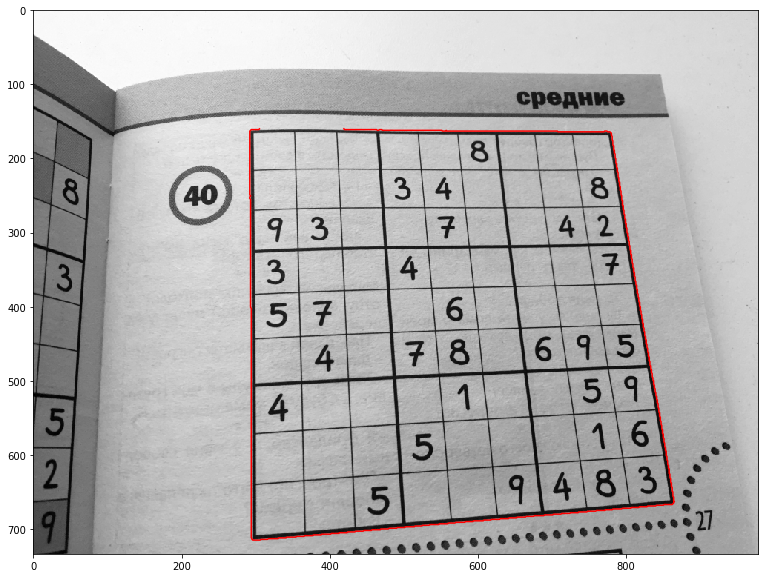

In [9]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(image_scaled, cmap=plt.cm.gray)
ax.plot(contour[:, 0], contour[:,  1], 'r')

## Step 3: finding the corners

### Another function looks for a similar close curve which should be as simple as possible 

In [10]:
# epsilon allow us to control the max deviation from the original curve 
# here we use 5% of the total curve lenth 
epsilon = 0.05 * cv2.arcLength(contour, True)
corners = cv2.approxPolyDP(contour, epsilon, True).squeeze()

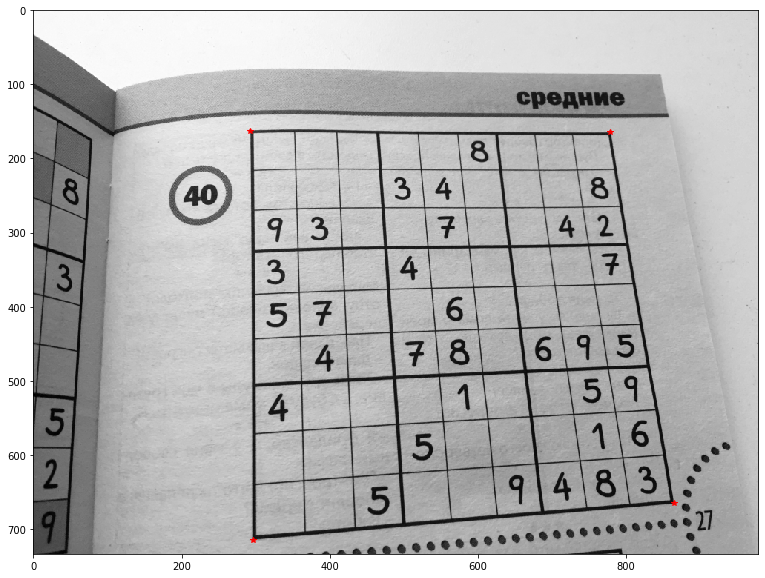

In [11]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(image_scaled, cmap=plt.cm.gray)
ax.plot(corners[:, 0], corners[:, 1], '*r')

In [12]:
corners

array([[292, 163],
       [296, 715],
       [864, 665],
       [778, 164]], dtype=int32)

In [13]:
desired = [0, 0, 0, 0]
desired[np.argmin(corners.sum(axis=1))] = [0, 0]
desired[np.argmax(corners.sum(axis=1))] = [700, 700]
idx_left = {0, 1, 2, 3} - {np.argmin(corners.sum(axis=1)), np.argmax(corners.sum(axis=1))}
topl = list(idx_left)[np.argmin(corners[list(idx_left)][:, 0])]
topr = list(idx_left)[np.argmax(corners[list(idx_left)][:, 0])]
desired[topl] = [0, 700]
desired[topr] = [700, 0]
desired

[[0, 0], [0, 700], [700, 700], [700, 0]]

In [14]:
from skimage.transform import ProjectiveTransform, warp

In [15]:
points_current = corners
points_desired = np.array(desired)

In [16]:
tform = ProjectiveTransform()
tform.estimate(points_desired, points_current)
image_warped = warp(image_scaled, tform)[:700, :700]

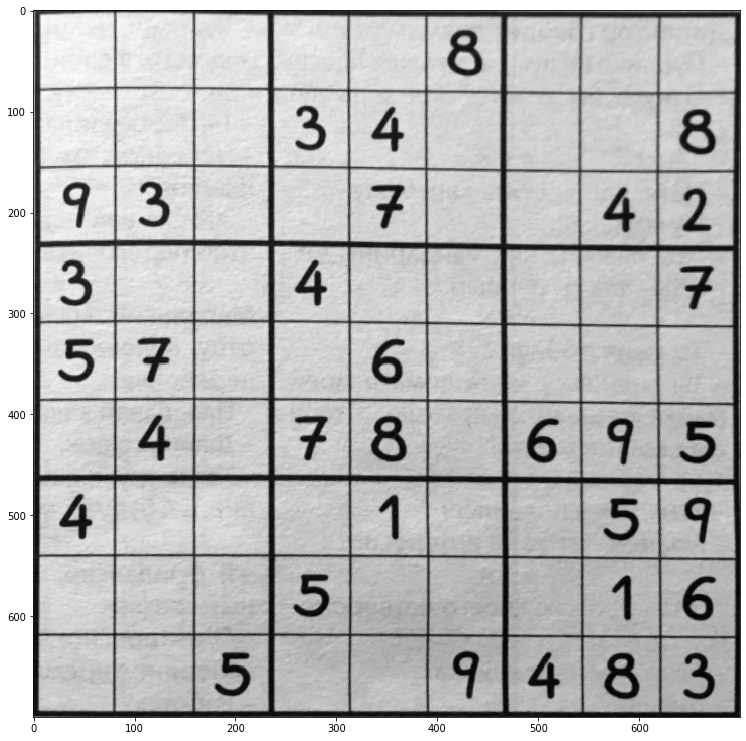

In [17]:
plt.figure(figsize=(13 ,13))
plt.imshow(image_warped, cmap=plt.cm.gray)

# Locate the numbers in cells

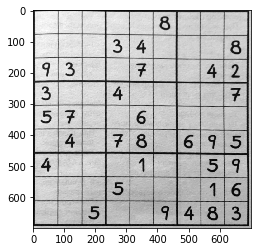

In [18]:
fname = './IMG_1263.JPG'
image_full = io.imread(fname, as_gray=True, plugin='matplotlib')
image_warped = normalize(image_full)
plt.imshow(image_warped, cmap='gray')

In [19]:
f = []
for (dirpath, dirnames, filenames) in os.walk('./templates/'):
    f.extend(filenames)
    break
templates, substitutes = [], []
for fname in sorted(f):
    img = io.imread(os.path.join(r'templates/', fname), as_gray=True, plugin='matplotlib')
    templates.append(cv2.resize(img, (700 // 10, 700 // 10)))
    s = cv2.resize(img, (700 // 10, 700 // 10))
    s = np.pad(s, 3, mode='constant', constant_values=0)
    s = np.vstack([np.zeros((1, 76)), s])
    s = np.hstack([np.zeros((77, 1)), s])
    substitutes.append(s)

(70, 70)


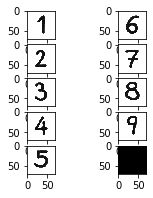

In [20]:
fig, ax = plt.subplots(5, 2, figsize=(3, 3))
for i, img in enumerate(templates):
    img[img > 0.5] = 1
    ax[i % 5, i // 5].imshow(img, cmap='gray')
print(templates[0].shape)

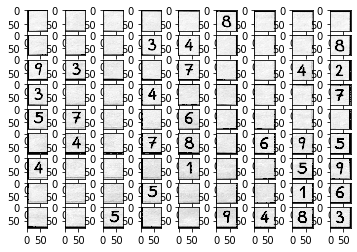

(77, 77)


In [21]:
# iterate over cells:
fig, ax = plt.subplots(9 ,9)

cells = []
for i in range(9):
    row = []
    for j in range(9):
        px_cell = 700 // 9
        crop = np.copy(image_warped[px_cell*i:px_cell*(i+1), px_cell*j:px_cell*(j+1)])
        crop[crop < 0.3] = 0
        row.append(crop)
        ax[i, j].imshow(crop, cmap='gray')
    cells.append(row)

cells = np.array(cells)
plt.show()
print(cells[0, 0].shape)

In [22]:
from skimage.feature import match_template

dig = np.zeros((9, 9))
c_max = np.zeros((9, 9))
corrs = []
# c_max = []
for i in range(9):
    row_corr = []
    for j in range(9):
#         result = match_template(cells[i, j], templates[0], pad_input=True)
        corr = np.array([match_template(cells[i, j], template, pad_input=True) for template in templates[:]])
        row_corr.append(np.max(corr))
        dig[i, j] = (1+np.argmax(corr.max(axis=(1,2)))) % 10
        c_max[i, j] = corr.max()
    corrs.append(row_corr)
corrs = np.array(corrs)

In [23]:
q = np.quantile(c_max, 0.6)
dig[c_max < q] = 0

In [24]:
dig

array([[0., 0., 0., 0., 0., 8., 0., 0., 0.],
       [0., 0., 0., 3., 4., 0., 0., 0., 8.],
       [9., 3., 0., 0., 7., 0., 0., 4., 2.],
       [3., 0., 0., 4., 0., 0., 0., 0., 7.],
       [5., 7., 0., 0., 6., 0., 0., 0., 0.],
       [0., 4., 0., 7., 8., 0., 6., 9., 5.],
       [4., 0., 0., 0., 1., 0., 0., 5., 9.],
       [0., 0., 0., 5., 0., 0., 0., 1., 6.],
       [0., 0., 5., 0., 0., 9., 4., 8., 3.]])

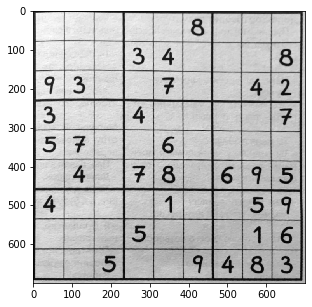

In [25]:
plt.figure(figsize=(5, 5))
plt.imshow(image_warped, cmap='gray')

Perfect match!

# Solve the sudoku

In [26]:
from sudoku import solve_sudoku
final = solve_sudoku(dig.astype(int))
final

array([[6, 2, 4, 9, 5, 8, 3, 7, 1],
       [1, 5, 7, 3, 4, 2, 9, 6, 8],
       [9, 3, 8, 1, 7, 6, 5, 4, 2],
       [3, 8, 6, 4, 9, 5, 1, 2, 7],
       [5, 7, 9, 2, 6, 1, 8, 3, 4],
       [2, 4, 1, 7, 8, 3, 6, 9, 5],
       [4, 6, 3, 8, 1, 7, 2, 5, 9],
       [8, 9, 2, 5, 3, 4, 7, 1, 6],
       [7, 1, 5, 6, 2, 9, 4, 8, 3]])

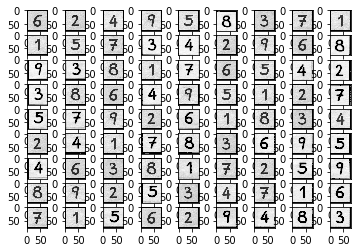

In [27]:
fig, ax = plt.subplots(9 ,9)

for i in range(9):
    for j in range(9):
        if not dig[i, j]:
            cells[i, j] = substitutes[final[i, j] - 1]
        ax[i, j].imshow(cells[i, j], cmap='gray')
plt.show()

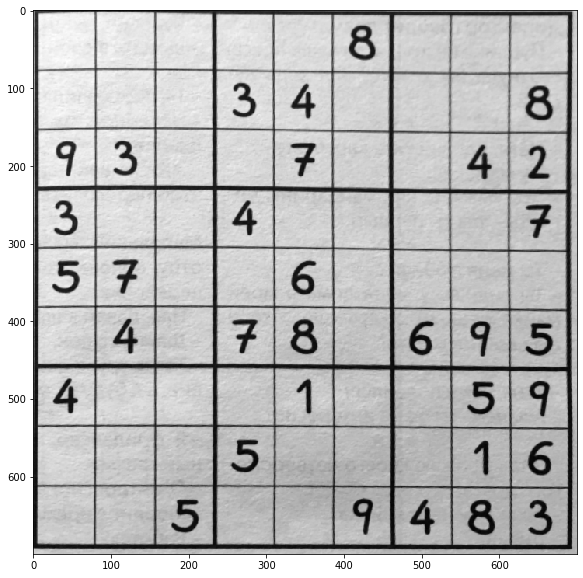

In [35]:
plt.figure(figsize=(10, 10))
plt.imshow(image_warped, cmap='gray')
plt.show()

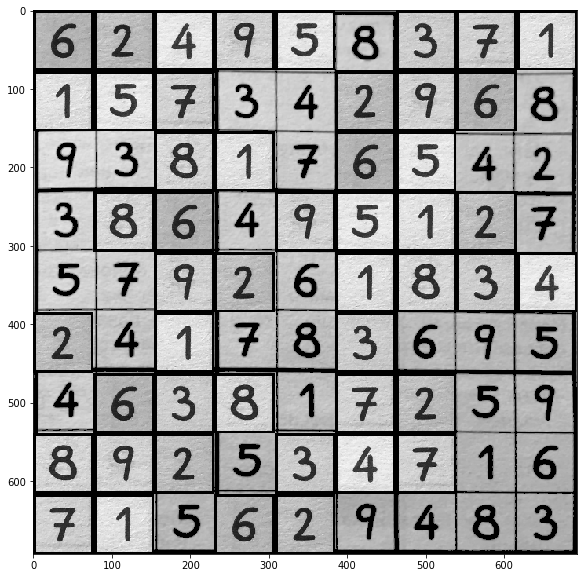

In [36]:
solved_img = np.hstack(np.hstack(cells))
plt.figure(figsize=(10, 10))
plt.imshow(solved_img, cmap='gray')
plt.show()

# Test of  functions from my lib on the examples

In [30]:
f = []
for (dirpath, dirnames, filenames) in os.walk('./examples2/'):
    f.extend(filenames)
    break
f = [name for name in f if 'img' in name.lower()]
f

['IMG_1265.JPG',
 'IMG_1274.JPG',
 'IMG_1272.JPG',
 'IMG_1269.JPG',
 'IMG_1283.JPG',
 'IMG_1262.JPG',
 'IMG_1270.JPG',
 'IMG_1266.JPG',
 'IMG_1273.JPG',
 'IMG_1281.JPG',
 'IMG_1268.JPG',
 'IMG_1267.JPG',
 'IMG_1275.JPG',
 'IMG_1289.JPG',
 'IMG_1280.JPG',
 'IMG_1271.JPG',
 'IMG_1276.JPG']

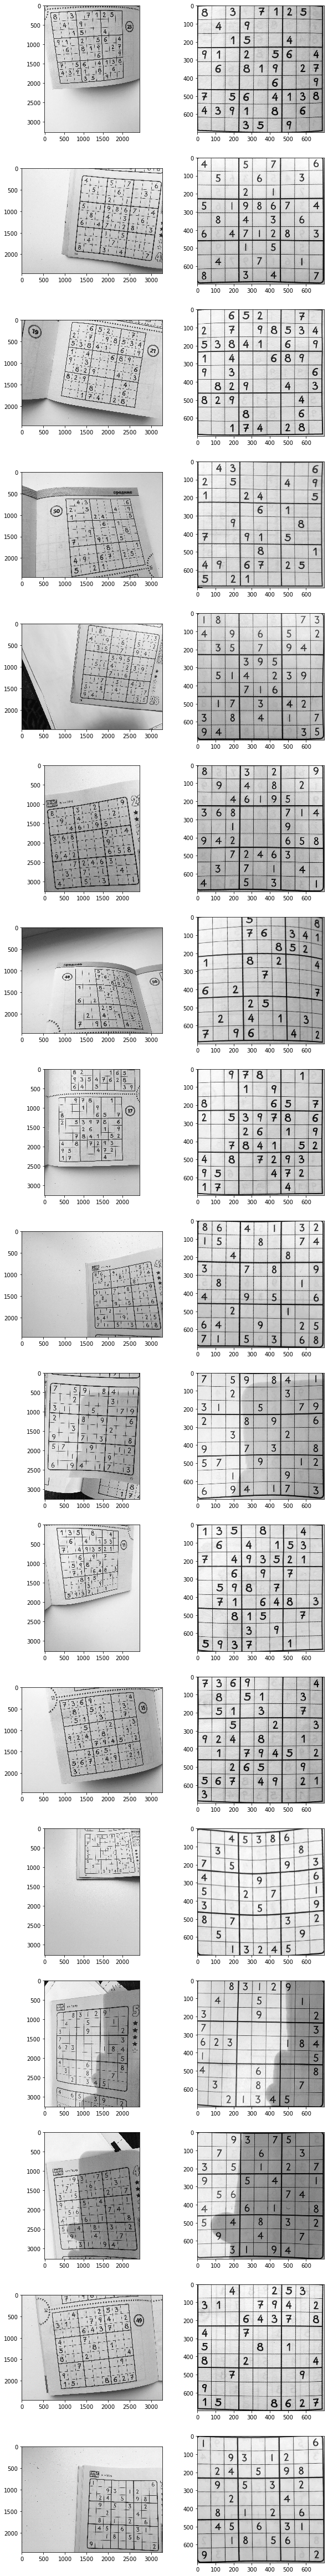

In [31]:
fig, ax = plt.subplots(len(f), 2, figsize=(2*5, len(f)*5))
for i, fname in enumerate(f):
    image_full = cv2.imread(r'examples2/' + fname, 0) / 255
    ax[i, 0].imshow(image_full, cmap='gray')
    ax[i, 1].imshow(normalize(image_full), cmap='gray')
plt.show()

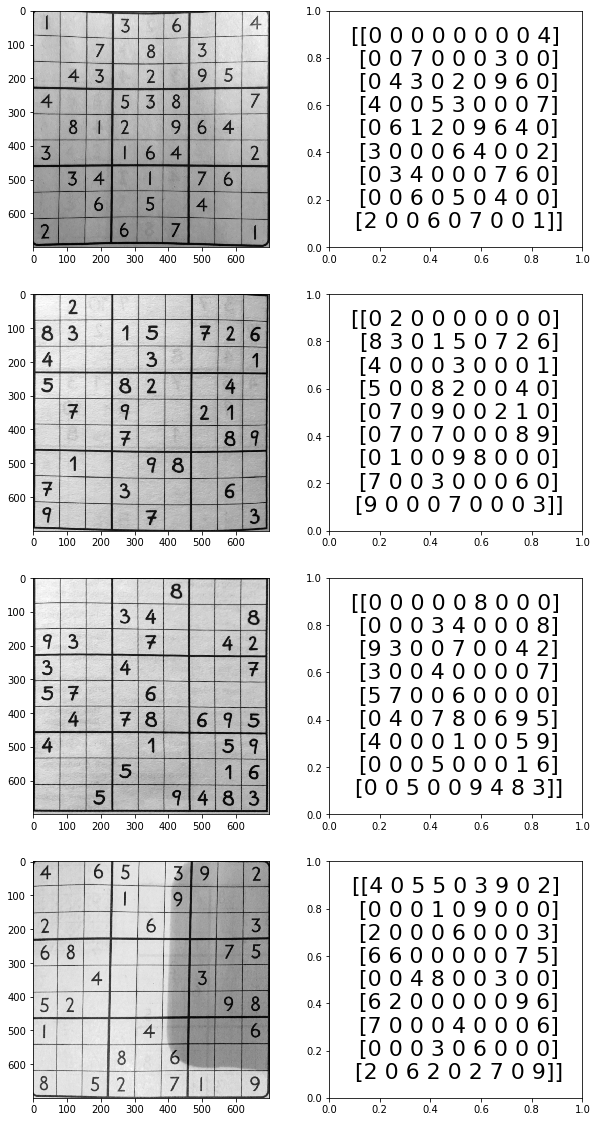

In [33]:
f = []
for (dirpath, dirnames, filenames) in os.walk('./'):
    f.extend(filenames)
    break
f = [name for name in f if 'img' in name.lower()]

fig, ax = plt.subplots(len(f), 2, figsize=(5 * 2, 5*len(f)))
for i, fname in enumerate(f):
    image_full = cv2.imread(r'./' + fname, 0) / 255
    n = normalize(image_full)
    digs = recognize_digits(n).astype(int)
    ax[i, 0].imshow(n, cmap='gray')
    ax[i, 1].text(0.5, 0.5, digs.__str__(), fontsize=22, horizontalalignment='center', verticalalignment='center', transform=ax[i, 1].transAxes)
#     print(recognize_digits(n), end)

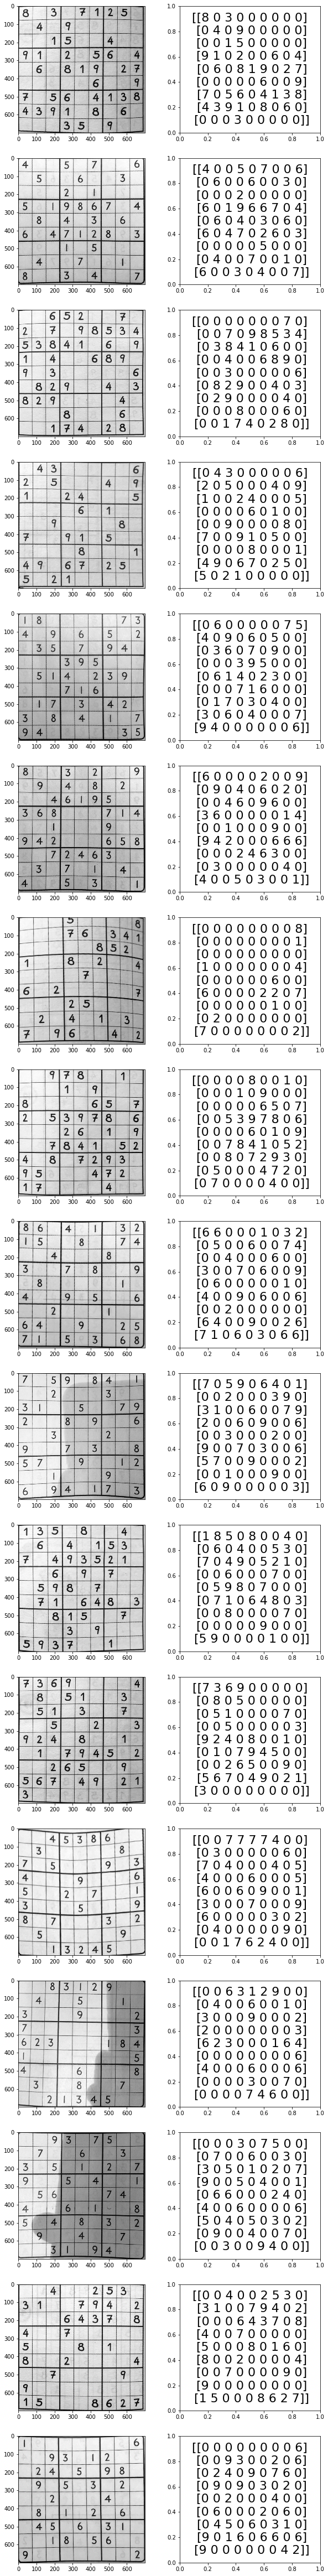

In [34]:
f = []
for (dirpath, dirnames, filenames) in os.walk('./examples2/'):
    f.extend(filenames)
    break
f = [name for name in f if 'img' in name.lower()]

fig, ax = plt.subplots(len(f), 2, figsize=(5 * 2, 5*len(f)))
for i, fname in enumerate(f):
    image_full = cv2.imread(r'./examples2/' + fname, 0) / 255
    n = normalize(image_full)
    digs = recognize_digits(n).astype(int)
    ax[i, 0].imshow(n, cmap='gray')
    ax[i, 1].text(0.5, 0.5, digs.__str__(), fontsize=22, horizontalalignment='center', verticalalignment='center', transform=ax[i, 1].transAxes)
#     print(recognize_digits(n), end)